# Part 1

In [841]:
import numpy as np
import matplotlib.pyplot as plt
import random
import numpy.linalg as la
from typing import List, Tuple, Callable
from tqdm import tqdm
from scipy.stats import multivariate_normal, norm
from scipy.fft import fft, fftfreq


Experimental Constants

In [842]:
BOLT_NUM = 17
FRAME_RATE = 240

Loading vibration Data

In [843]:
data_dict = dict(np.load(r'data\\AutonomousTrajectoriesBig.npz'))
data_all = [it[1] for it in data_dict.items()]

In [844]:
data_dict.keys()

dict_keys(['T10', 'T11', 'T13', 'T20', 'T4', 'T18', 'T3', 'T14', 'T5', 'T17', 'T9', 'T23', 'T24', 'T21', 'T7', 'T6', 'T22', 'T12', 'T19', 'T15', 'T1', 'T2', 'T8', 'T16'])

In [845]:
print(len(data_all))
data_all[0].shape

24


(17, 7453)

# 1.1
 Reversing columns of the data matrices, so that data is in increasing time

In [846]:
raw_data = []
for data_mat in data_all:
    raw_data.append(data_mat[:, ::-1])

# ensuring that the data is reversed correctly
for mat_reverse, mat_forward in zip(data_all, raw_data):
    assert np.allclose(mat_reverse[:, ::-1], mat_forward)


In [847]:
print(raw_data[0][0, :])
print(data_all[0][0, :])
raw_data[0].shape


[ 0.04094743  0.02806029  0.00584782 ...  0.0129485  -0.00066601
  0.00832467]
[ 0.00832467 -0.00066601  0.0129485  ...  0.00584782  0.02806029
  0.04094743]


(17, 7453)

At this point it's probably a good idea to visualise the data to get a clearer picture of the signal and any steady states

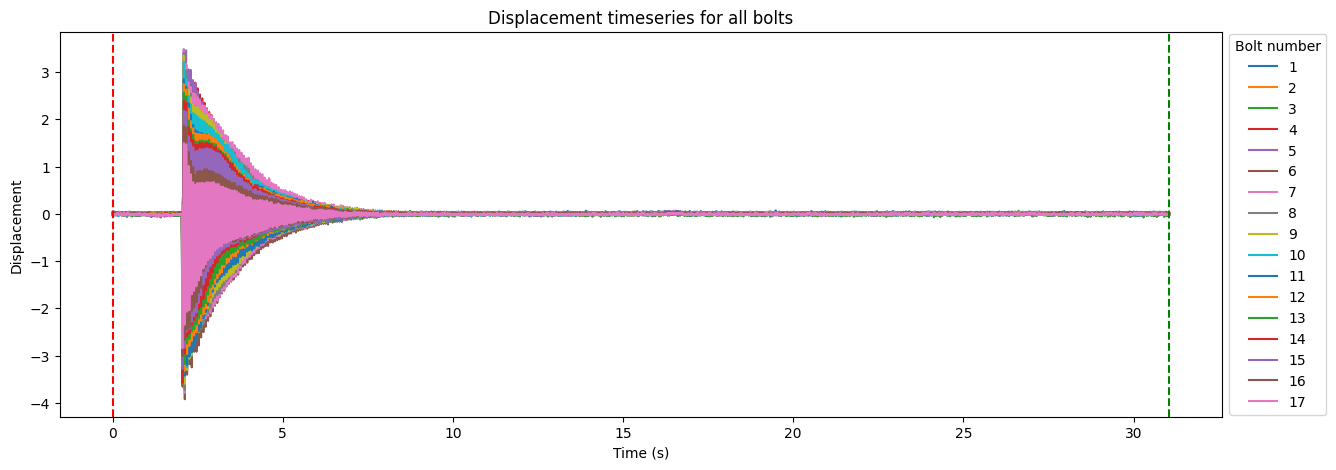

In [848]:
def get_time_from_frames(frames):
    t_final = frames / FRAME_RATE
    t = np.linspace(0, t_final, frames)
    return t

def plot_timeseries(data, start=0, stop=-1, fig_size=(15, 5), show_legend=True):
    fig, ax = plt.subplots(1, 1, figsize=fig_size)
    
    if stop == -1:
        stop = data.shape[1]

    # time of each measurement is determined based on the camera frame rate and the number of columns in the data array
    frame_count = data.shape[1]
    t = get_time_from_frames(frame_count)
    
    # t = t[start:stop+1]
    # plotting the timeseries data for each bolt
    for i in range(BOLT_NUM):
        ax.plot(t, data[i, :], label=f'{i+1}')
    
    ax.axvline(x=t[start], color='r', linestyle='--')
    ax.axvline(x=t[stop-1], color='g', linestyle='--')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Displacement')

    if show_legend:
        ax.legend(title='Bolt number', loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.title('Displacement timeseries for all bolts')
    plt.show()

plot_timeseries(raw_data[0], start=0, stop=-1)



# 1.2 
We can clearly see the initial steady state and the long time steady state from the above plot. We can also observe some variation in the initial amplitude of oscillation for the different bolts, as well as in the steady state noise. Let's visualise the minimum and maximum absolute displacement for one of the time series in the dataset, to determine a simple approach for removing steady state data.

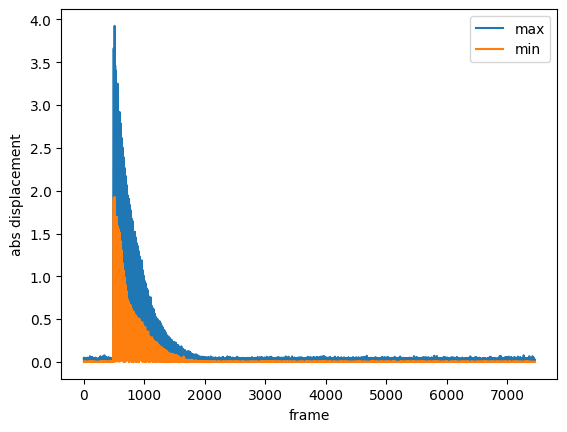

In [849]:
max_series = np.max(np.abs(raw_data[0]), axis=0)
min_series = np.min(np.abs(raw_data[0]), axis=0)
plt.plot(max_series, label="max")
plt.plot(min_series, label="min")
plt.legend()
plt.xlabel('frame')
plt.ylabel('abs displacement')
plt.show()

We can see that there is a clear spike in both the maximum and minimum absolute displacement (distance I suppose) and that the steady state noise for the maximum timeseries is consistently higher than the steady state noise for the minimum. We can use this to our advantage to seperate the transient behaviour from steady state, by selecting the maximum of the maximum absolute displacement timeseries for t>20, then using this as a threshold on the minimum displacement.

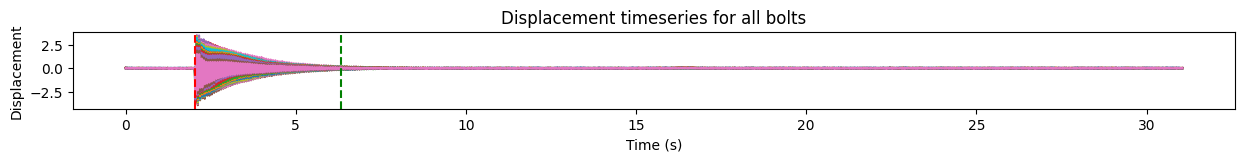

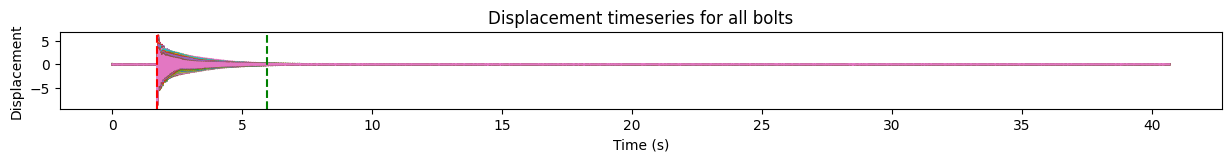

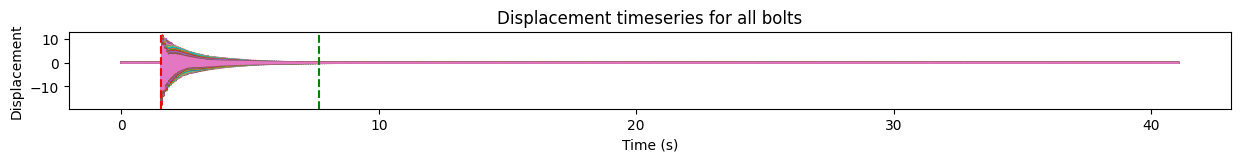

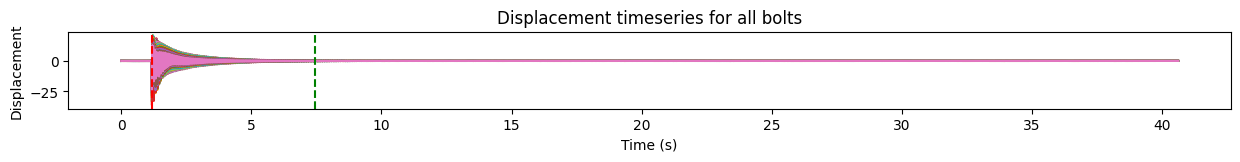

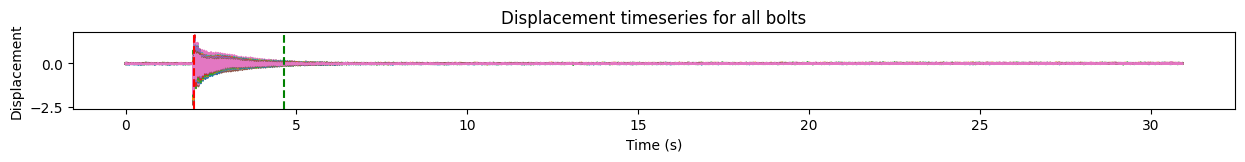

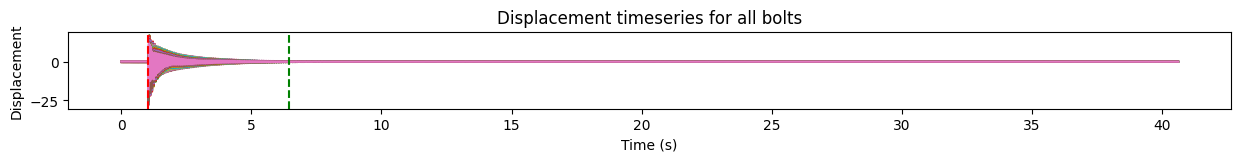

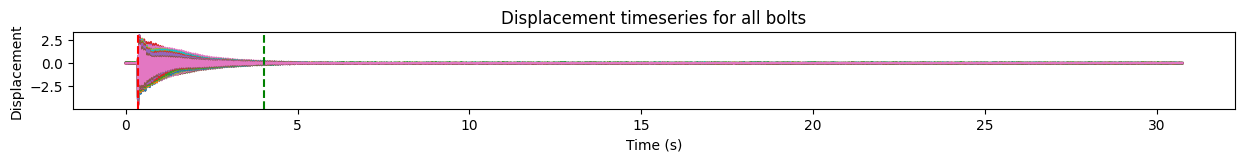

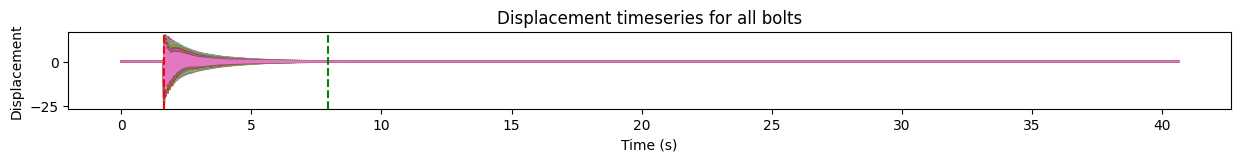

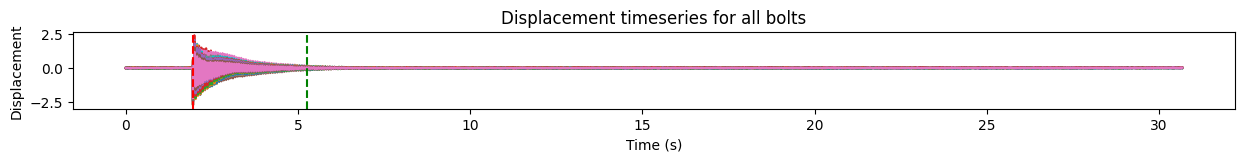

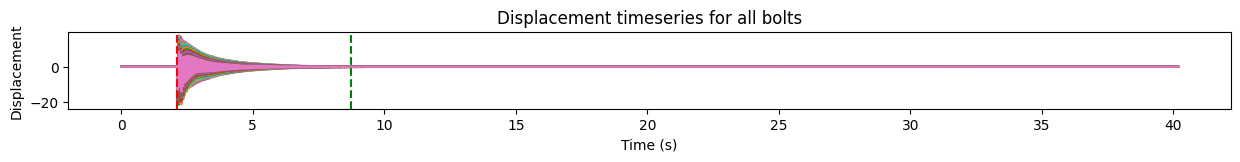

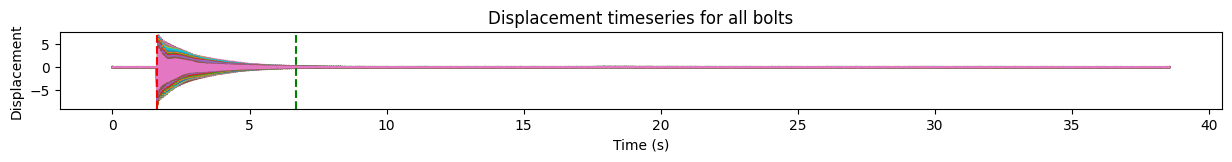

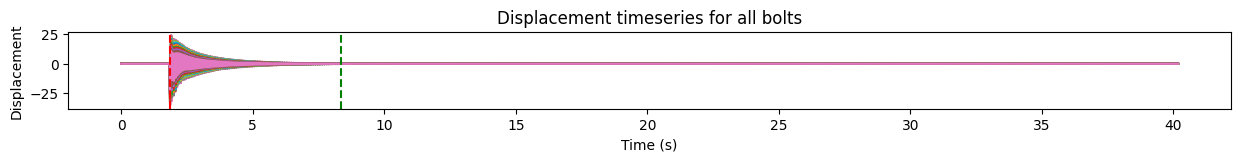

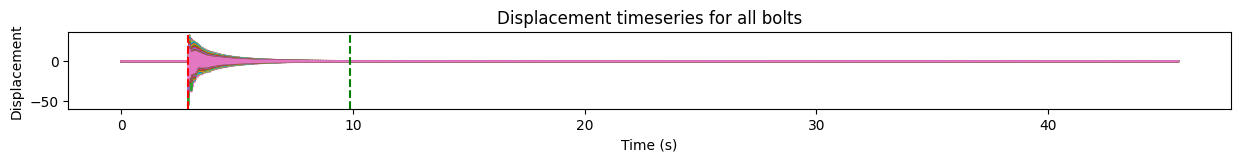

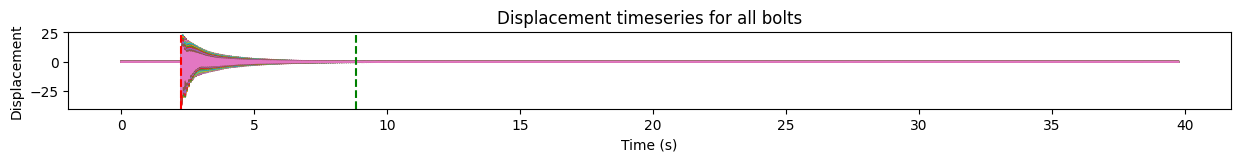

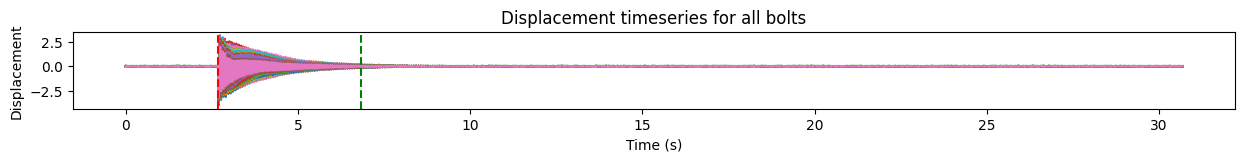

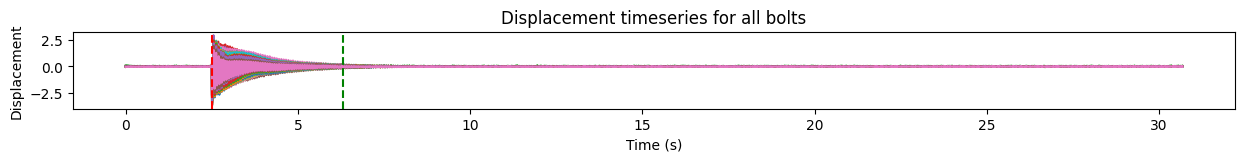

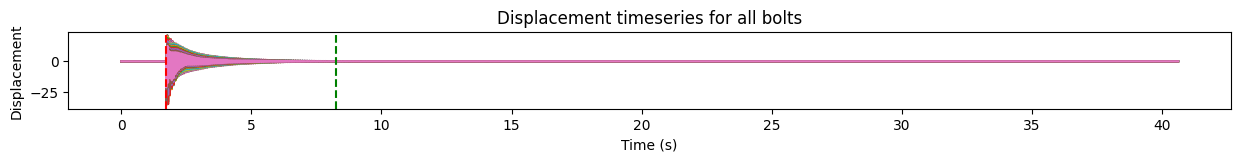

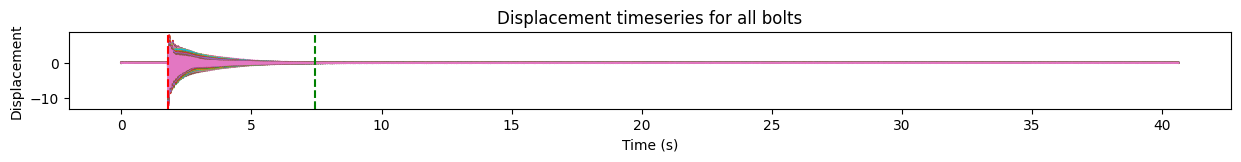

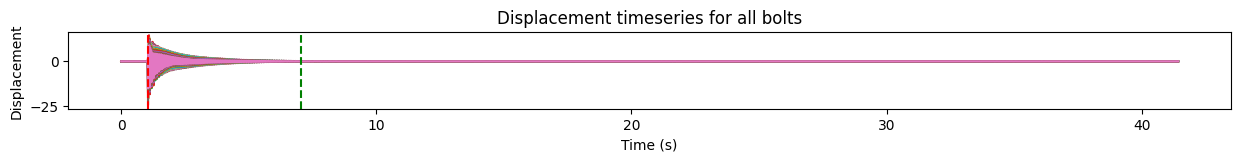

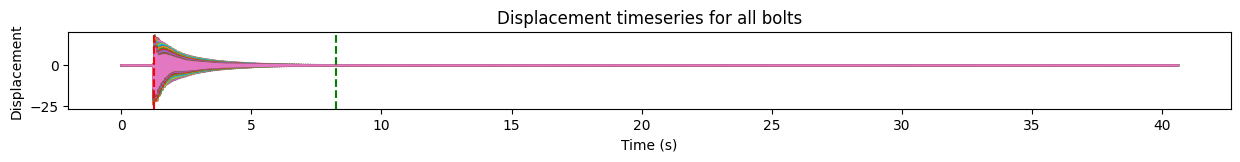

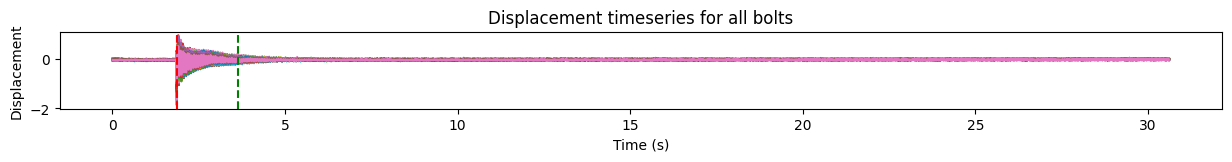

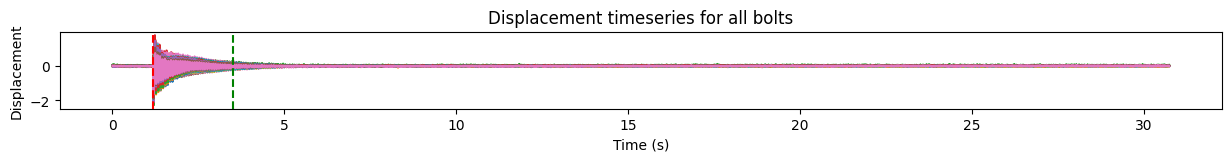

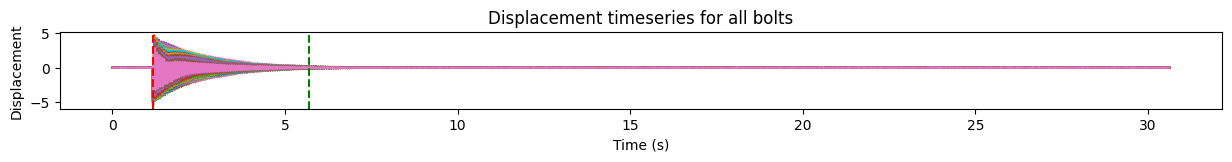

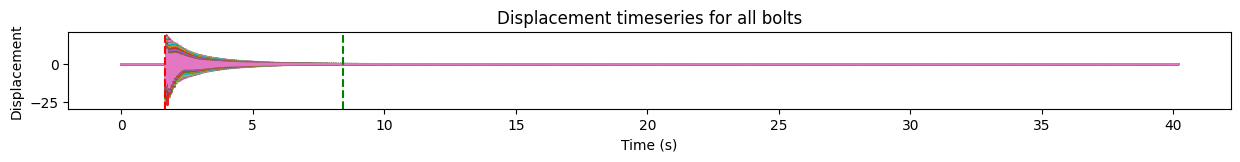

In [850]:
def find_steady_state(data):
    # timeseries of min and max distance from 0 for each bolt
    max_series = np.max(np.abs(data), axis=0)
    min_series = np.min(np.abs(data), axis=0)

    # getting the largest distance from the steady state max_series after t=20s
    t = get_time_from_frames(data.shape[1])
    steady_start = np.where(t > 20)[0][0]
    threshold = np.max(max_series[steady_start:]) 
    
    # getting indices of the transient state using max steady state threshold
    transient_indices = np.where(min_series > threshold)[0]
    
    # stop at the last transient index
    stop = transient_indices[-1]
    start = transient_indices[0]
    
    return start, stop

# visually validating the start and stop positions
processed_data = []
for i, data in enumerate(raw_data):
    start, stop = find_steady_state(data)
    plot_timeseries(data, start=start, stop=stop, fig_size=(15, 1), show_legend=False)
    # trimming the data
    processed_data.append(data[:, start:stop])

In this case, since we have a relatively small number of trials, I can visually verify that this simple filtering approach has worked as intended. For a larger data set, perhaps a slightly more robust approach would be required.

# 1.3
Now let's ensure that each trajectory has zero mean (oscillation about 0 displacement). 

In [851]:
def zero_mean(data):
    return data - np.mean(data, axis=1, keepdims=True)

processed_data = [zero_mean(data) for data in processed_data]

# validating that zeroing the mean has worked
for data in processed_data:
    assert np.allclose(np.mean(data, axis=1), 0, rtol=1e-15), 'Mean is not zeroed to machine precision'

We cannot trust that the steady state is at the same numerical value for all trajectories for three possible reasons. One is that there may be some uncertainty associated with the tracking of each bolt using computer vision. Two, there may be some camera distortions such as fish eye that have not been properly accounted for, leading to increasing measurement error for bolts away from the centre of the camera frame. Finally, the experimental setup doesn't appear to be rigorously leveled, so the physical location of the bolts may not actually lie on a perfectly level straight line. 

### 1.4
We do not know that the damping in the system is linear, therefore we cannot be certain that it is independent of the magnitude of displacement, so the rescaling should take place accross all matrices aggregated instead of individually. scaling values between 1 and -1 can be benificial for numerical stability, since it reduces the scale difference between small and large losses. If we collected more data, we would need to rescale it the same amount as the original data, so it's generally a good idea to keep track of the scaling factor. Here we are not going to be dealing with further data, so I will not.

In [852]:
print("shape pre scaling", processed_data[0].shape, "\n")

scale = -np.inf
for data in processed_data:
    abs_max = np.max(np.abs(data))
    if abs_max > scale:
        scale = abs_max

print("max absolute displacement in dataset =", scale)
print("---------------------------------------")

for i, data in enumerate(processed_data):
    processed_data[i] = data / scale

# validating that the data has been scaled correctly. There should be a 1 present in the list
for i, data in enumerate(processed_data):
    max_displacement = np.max(np.abs(data))
    assert (max_displacement <= 1), 'Data is not scaled correctly'
    print("test {}, max displacement = {}".format(i, max_displacement))

# checking the shape of the data remains unchanged
print("\nshape post scaling", processed_data[0].shape)

shape pre scaling (17, 1029) 

max absolute displacement in dataset = 55.46600266290267
---------------------------------------
test 0, max displacement = 0.06985011878146498
test 1, max displacement = 0.15675990755397168
test 2, max displacement = 0.3231608920870714
test 3, max displacement = 0.6553487638960437
test 4, max displacement = 0.04281049391076513
test 5, max displacement = 0.5073179110590731
test 6, max displacement = 0.08105039330085374
test 7, max displacement = 0.4435932784550382
test 8, max displacement = 0.04901883259086211
test 9, max displacement = 0.39190776225625984
test 10, max displacement = 0.14821380801316614
test 11, max displacement = 0.6315495385753634
test 12, max displacement = 1.0
test 13, max displacement = 0.6657811659736601
test 14, max displacement = 0.0722840014285362
test 15, max displacement = 0.06501025213200393
test 16, max displacement = 0.6533942719476019
test 17, max displacement = 0.21652699079428922
test 18, max displacement = 0.445442485892

### plotting the final dataset as a sanity check


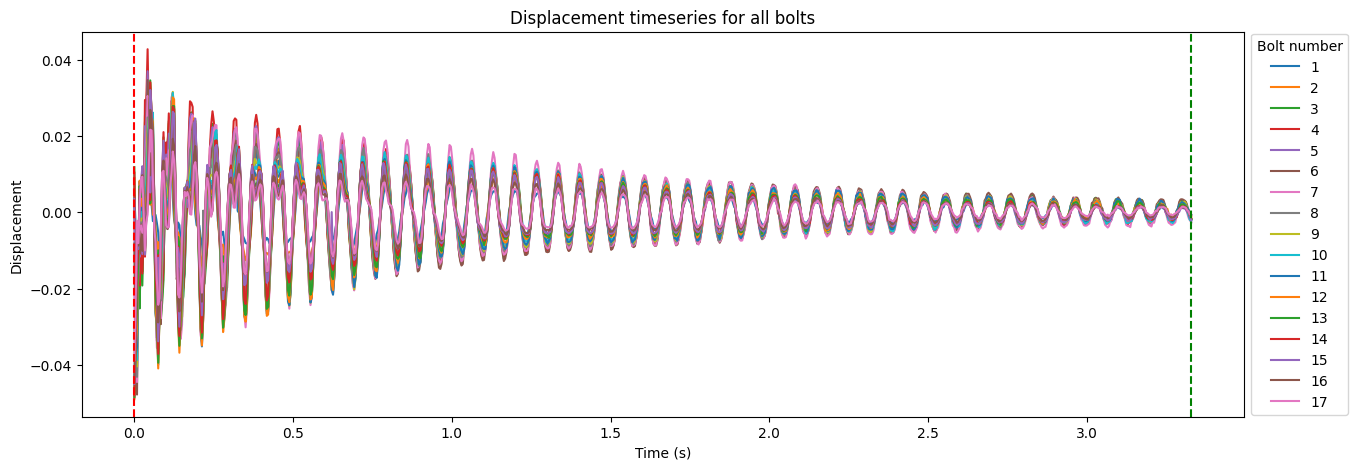

In [853]:
plot_timeseries(processed_data[random.randint(0, len(processed_data)-1)], start=0, stop=-1)

# 1.5
We can visualise the power spectrum of the timeseries data using the FFT. Spikes in the power spectrum tell us the frequencies of the dominant sinusoids that approximate the signal.

In [854]:
def visualise_power_spectra(data, start, stop=None):
    power_spectra = []
    for i in range(len(raw_data)):
        # Extract the timeseries data
        timeseries_data = raw_data[i][:, start:stop]
        timeseries_data = timeseries_data.flatten() # flattening to combine steady state data for all bolts

        # Number of samples
        N = len(timeseries_data)

        # Compute the FFT
        fft_values = fft(timeseries_data)

        # Compute the corresponding frequencies
        frequencies = fftfreq(N, 1 / FRAME_RATE)

        # Compute the power spectrum
        power_spectrum = np.abs(fft_values)**2

        power_spectra.append((frequencies, power_spectrum))

    # Plot the power spectrum
    plt.figure(figsize=(10, 5))
    for trail_num, (frequencies, power_spectrum) in enumerate(power_spectra):
        pos_inds = np.where(frequencies > 0) # Plot only the positive frequencies
        plt.plot(frequencies[pos_inds], power_spectrum[pos_inds], label=str(trail_num))  
    plt.yscale('log')
    # plt.xscale('log')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.title('Power Spectrum of the Timeseries Data')
    plt.grid(True)
    plt.legend(title='Trail number', loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

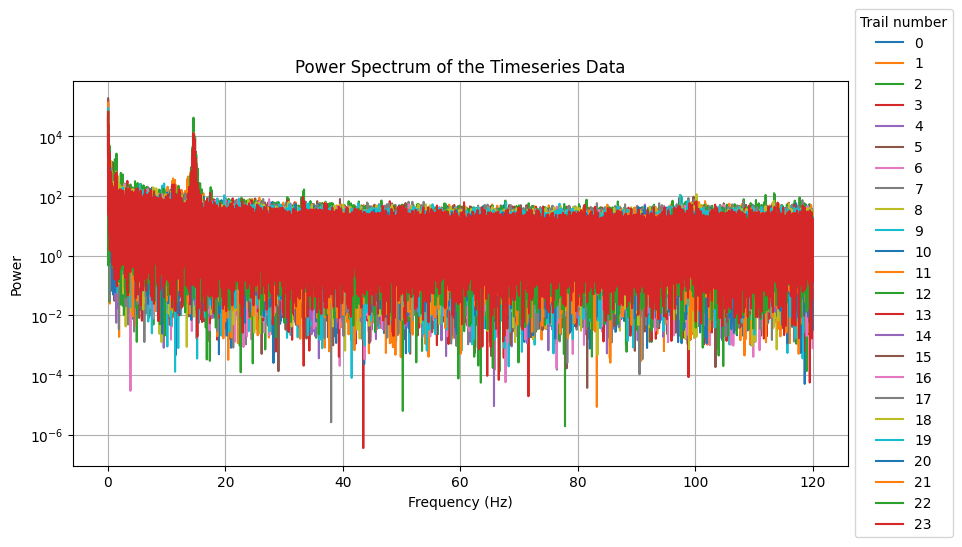

In [855]:
# getting the steady state as before
t = np.linspace(0, raw_data[0].shape[1] / FRAME_RATE, raw_data[0].shape[1])
steady_start = np.where(t > 20)[0][0]

visualise_power_spectra(raw_data, start=steady_start)

We see that there is a notable spike in the power spectrum around 17 Hz for all of the trials. If we then look at the power spectrum for the transient data in processed_data, we see that the dominant frequency in the power series again occurs at around 17Hz. This suggests that even in the apparently steady state behaviour of the system the metal plate is still vibrating at 17Hz with very low amplitude.

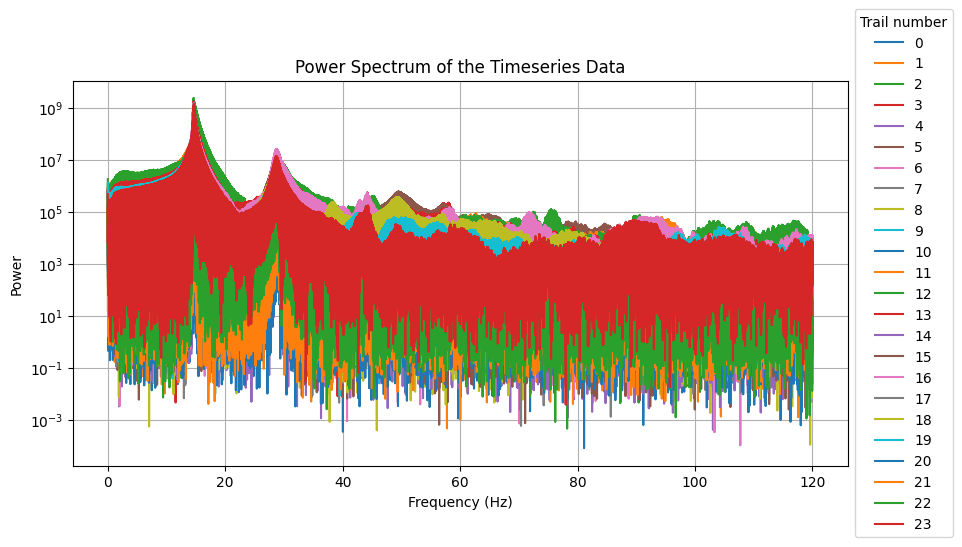

In [856]:
visualise_power_spectra(processed_data, start=0)

# 2.1

It is necissary to seperate the data into a training and testing set to ensure that our model is not overfit to the training data. If it performs well on the training data, but poorly on the test data, the model is likely overfit.

Let's simply do a 50-50 split

In [857]:
train_ratio = 0.5
shuffled_data = random.sample(processed_data, len(processed_data))
train_data = shuffled_data[:int(len(shuffled_data)*train_ratio)]
test_data = shuffled_data[int(len(shuffled_data)*train_ratio):]

print(len(train_data), len(test_data))

12 12


# 2.2

We are using delay embedding to determine the states and linear model which generate the observed data. Assuming that the system is observable. In this case If we assume the system is observable, we have the equations

$$
\bm{x}_{k+1} = A\bm{x}_k \\
\bm{y}_k = C\bm{x}_k
$$

where $\bm{y}_k \in \R^{17}, \,\, \bm{x}_k \in \R^{d^*}, \forall k$ where $d^*$ is the unkown dimensionality of the state space of the data. 

if the system is observable then a surrogate of the unkown state space is 

$$
\bm{\hat{x}}_k = \begin{pmatrix} \bm{y}+k \\ \vdots \\ \bm{y}_{k+d-1} \end{pmatrix}
$$

where $d$ is some sufficiently large delay embedding. If we consider multiple observations of the state surrogate taking unit steps in time, we end up with the hankel matrix

$$
X =
\begin{pmatrix}
    \bm{y}_1 & \bm{y}_2 & \cdots & \bm{y}_{N-d+1} \\
    \bm{y}_2 & \bm{y}_3 & \cdots & \bm{y}_{N-d+2} \\
    \vdots   & \vdots   & \ddots & \vdots \\
    \bm{y}_d & \bm{y}_{d+1} & \cdots & \bm{y}_N
\end{pmatrix}
$$

We can decorrelate $X$ row wise to get $\hat{X}$ so that that the rows of the delay embedding matrix are as close to independent as possible. Since the rows correspond to timeseries of each of the delay dimensions, this amounts to ensuring that the timeseries encode unique information and helps with numerical stability. To fit a linear model to this decorrelated delay embedding matrix, we can consider

$$
X_\mathrm{prev} = \hat{X}[:, :-1] \\
X_\mathrm{next} = \hat{X}[:, 1:]
$$

and train a linear model to predict the next state surrogate from the previous

$$
\bm{\hat{x}}_{k+1} = W\bm{\hat{x}}_{k}
$$

If we want to extract the predicted next output state from $\bm{\hat{x}}_{k+1}$ (unseen $\bm{y}_{d+1}$ in above example) then we need to compute
$$
\bm{y}_k = \hat{U}[-17:,:]\bm{\hat{x}}_k
$$
which corresponds to the last delay embedding entry in $\bm{\hat{x}}_{k+1}$

In [858]:

def hankel_matrix(data: np.array, delay: int):
    """
    Generates a hankel matrix by vertically stacking the delayed versions of the data matrix by delay timesteps
    args:
    ------
    data: np.array, timeseries of shape (n,m) where m is the number of timesteps and n is the number of features
    delay: int, delay window size

    returns:
    --------
    hankel: np.array, hankel matrix of shape (delay*n, m-delay+1)
    """
    n = data.shape[0]
    m = data.shape[1]
    
    hankel = np.zeros((delay*n, m-delay+1))
    for i in range(delay):
        hankel[i*n:(i+1)*n, :] = data[:, i:m-delay+(i+1)] 
    
    return hankel

# let's test that this implementation is correct with a small test vector
simple_hankle_test = np.array([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
hankle_test_mat = hankel_matrix(simple_hankle_test, 4)
print("1D test:")
print(hankle_test_mat)
# and with multidimensional data
simple_hankle_test = np.array([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
simple_hankle_test = np.vstack((simple_hankle_test, simple_hankle_test))
hankle_test_mat = hankel_matrix(simple_hankle_test, 4)
print("2D test:")
print(hankle_test_mat)



1D test:
[[ 1.  2.  3.  4.  5.  6.  7.]
 [ 2.  3.  4.  5.  6.  7.  8.]
 [ 3.  4.  5.  6.  7.  8.  9.]
 [ 4.  5.  6.  7.  8.  9. 10.]]
2D test:
[[ 1.  2.  3.  4.  5.  6.  7.]
 [ 1.  2.  3.  4.  5.  6.  7.]
 [ 2.  3.  4.  5.  6.  7.  8.]
 [ 2.  3.  4.  5.  6.  7.  8.]
 [ 3.  4.  5.  6.  7.  8.  9.]
 [ 3.  4.  5.  6.  7.  8.  9.]
 [ 4.  5.  6.  7.  8.  9. 10.]
 [ 4.  5.  6.  7.  8.  9. 10.]]


This deccorelation function can be used in our delay embedding procedure to create the state surrogate from the hankel matrix. The process of decorrelation removes any strongly correlated information between rows of the state surrogate, which will improve the model performance.

In [859]:
def decorrelate(data: np.array, kappa: float = 1e6, verbose: bool = True):
    """
    args:
    ------
    data: np.array, data matrix to decorrelate, row wise, shape (n, m) 
    kappa: float, stability condition for the singular values

    returns:
    --------
    decorrelated: np.array, decorrelated data matrix, row wise, shape (n*, m), where n* 
    corresponds to the number of stable singular values
    U: np.array, left singular vectors of the data matrix that satisfy the stability, shape (n, n*)

    """
    # performing SVD on the correlation matrix
    cor_mat = data @ data.T
    U, s_vec, _ = np.linalg.svd(cor_mat, full_matrices=False, hermitian=True) # economy svd and correlation matrix is symmetric
    # selecting columns of u that satisfy stability condition
    significant_cols = np.where(s_vec[0] / s_vec < kappa)[0]
    U = U[:, significant_cols]
    decorrelated = U.T @ data

    if verbose:
        print("Decorrelating data: \n")
        print(" data shape: ", data.shape, "\n")
        print(" first 5 singular values: ", s_vec[:5], "\n")
        print(" U shape after filtering: ", U.shape, "\n")
        print(" decorrelated data shape: ", decorrelated.shape, "\n")
        print("-----------------------------\n")
    if decorrelated.shape != data.shape:
        print("decorrelated matrix has less rows that input data for numerical stability")
        
    return decorrelated, U

# simple decorrelation test
simple_decor, simple_U = decorrelate(hankle_test_mat, kappa=1e6)
print("\ndecorrelated test:")
print(simple_decor)
# and returning to correlated space
simple_correlated = simple_U @ simple_decor
print("\nrecovered state surrogate:")
print(simple_correlated)

Decorrelating data: 

 data shape:  (8, 7) 

 first 5 singular values:  [1.98008113e+03 7.91886744e+00 2.04821440e-13 1.03887481e-13
 4.65642867e-14] 

 U shape after filtering:  (8, 2) 

 decorrelated data shape:  (2, 7) 

-----------------------------

decorrelated matrix has less rows that input data for numerical stability

decorrelated test:
[[ -7.51994279 -10.30349632 -13.08704986 -15.87060339 -18.65415693
  -21.43771046 -24.221264  ]
 [  1.85754151   1.35571514   0.85388876   0.35206238  -0.149764
   -0.65159038  -1.15341676]]

recovered state surrogate:
[[ 1.  2.  3.  4.  5.  6.  7.]
 [ 1.  2.  3.  4.  5.  6.  7.]
 [ 2.  3.  4.  5.  6.  7.  8.]
 [ 2.  3.  4.  5.  6.  7.  8.]
 [ 3.  4.  5.  6.  7.  8.  9.]
 [ 3.  4.  5.  6.  7.  8.  9.]
 [ 4.  5.  6.  7.  8.  9. 10.]
 [ 4.  5.  6.  7.  8.  9. 10.]]


We see that since rows of this test matrix are highly correlated, the decorrelation process actually reduced the number of rows for stability reasons.

Now we need to fit a linear model to the delay embedded and decorellated data to produce the observed output data. When calculating the prediction error, we can avoid the issue of varying dimensionality, by calculating loss in the observation space instead of surrogate state space.

In [860]:
def linear_delay_embedding(data: np.array, delay: int = 10, kappa: float = 1e6, svd_rank: int = None):
    """
    Fits a least squares linear model to predict the next state surrogate from the previous state surrogate
    using a delay embedding size given by delay. 

    args:
    -----
    data: np.array, timeseries of shape (n, m) where m is the number of timesteps and n is the number of features 
    delay: int, delay embedding window size
    kappa: float, threshold for decorrelation
    svd_order: int, number of singular values to keep for decorrelation, if None, all singular values are kept (this is for question 3)
    
    returns:
    --------
    W: np.array, linear model weights for predicting the next state surrogate from the previous state surrogate, shape (n*delay, n*delay)
    U: np.array, LHS Matrix from SVD, for switching between decorrelated state surrogate and observed/predicted outputs (n, n*delay)
    X_prev: np.array, decorrelated previous state surrogate matrix (n*delay, m-delay+1)
    X_next: np.array, decorrelated next state surrogate matrix (n*delay, m-delay+1)
    """
    # delay embedding the observed outputs 
    hankel = hankel_matrix(data, delay)
    # previous timestep and next timestep state surrogate matrices
    X_prev = hankel[:, :-1]
    X_next = hankel[:, 1:]
    # decorrelated input state surrogate matrix
    _, U = decorrelate(hankel, kappa=kappa, verbose=False)
    # truncating the left singular vectors to svd_order
    U = U[:, :svd_rank]
    # decorrelated state surrogates
    X_prev = U.T @ X_prev # shape (n* * delay, m-delay)
    X_next = U.T @ X_next # this is the target for the linear model

    # fitting a linear model to predict the next surrogate state, i.e. X_next = W @ X_prev
    W = (X_next @ X_prev.T) @ la.pinv(X_prev @ X_prev.T, rcond=1e-8)

    return W, U, X_prev, X_next

def predict(W: np.array, U: np.array, data: np.array, delay: int = 10):
    """
    predicts the output state at the next timestep using the linear delay embedding model, 
    with learned weights W and delay d, with decorrelation matrix U.
    
    args:
    -----
    W: np.array, linear model weights
    U: np.array, LHS Matrix from SVD, for decorrelation
    data: np.array, test trajectory of shape (n,m) where m is the number of timesteps and n is the number of features
    delay: int, delay embedding window size

    returns:
    --------
    Y_pred: np.array, predicted output state starting at column index i=delay in the input data matrix and finishing at 
            the final column, shape (n, m-delay)
    prediction_rmse: float, root mean squared error of the prediction vs the actual output
    """
    # delay embedding matrix
    hankel = hankel_matrix(data, delay)
    # decorrelated previous state surrogate matrix
    X_prev = U.T @ hankel[:, :-1]
    
    # predicting the next state surrogate
    X_next_pred = W @ X_prev
    
    # predicting the output to the unseen data (i.e one timestep ahead of the delay embdedding for each column of X_next_pred)
    Y_pred = U[-data.shape[0]:, :] @ X_next_pred
    Y_actual = data[:, delay:] 
    
    # to avoid the delay affecting the rmse, we can go back to the output space and calculate the rmse
    # between the predicted and observed outputs (taking into account the delay)

    # calculating the rmse for each timestep over the 17 bolts
    rmse = la.norm(Y_pred - Y_actual, axis=0) / np.sqrt(Y_actual.shape[0]) # shape (m-d,) 

    # Original approach using the state surrogates and scaling by norm. decided on using the output space instead
    # Rescaled to account for the dimensionality of the data (mean term cancels out)
    # rmse = la.norm(X_next - X_next_pred, axis=0) / la.norm(np.ones(X_next.shape[0]))
    # standard deviation of rmse accross features
    
    # mean error is then taken over each timestep
    mean_error = np.mean(rmse)
    std_error = np.std(rmse)

    return Y_pred, mean_error, std_error

# training and testing the linear delay embedding model
stacked_train_data = np.hstack(train_data) 
stacked_test_data = np.hstack(test_data)

delay = 5 # test delay size
kappa = 1e6
W, U, _, _ = linear_delay_embedding(stacked_train_data, delay=delay, kappa=kappa)

_, train_error_mean, _ = predict(W, U, stacked_train_data, delay=delay)
test_preds, test_rmse, _ = predict(W, U, stacked_test_data, delay=delay)

print("test with delay = ", delay)
print("mean train rmse: ", train_error_mean)
print("mean test mse rmse: ", test_rmse)


test with delay =  5
mean train rmse:  0.0020302457386438964
mean test mse rmse:  0.002259122372299664


Now that we have a delay embedding regime that appears to work, lets just do a quick sanity check to validate that it is correctly predicting outputs

test series shape (14089,)
Y_pred shape (14089,)


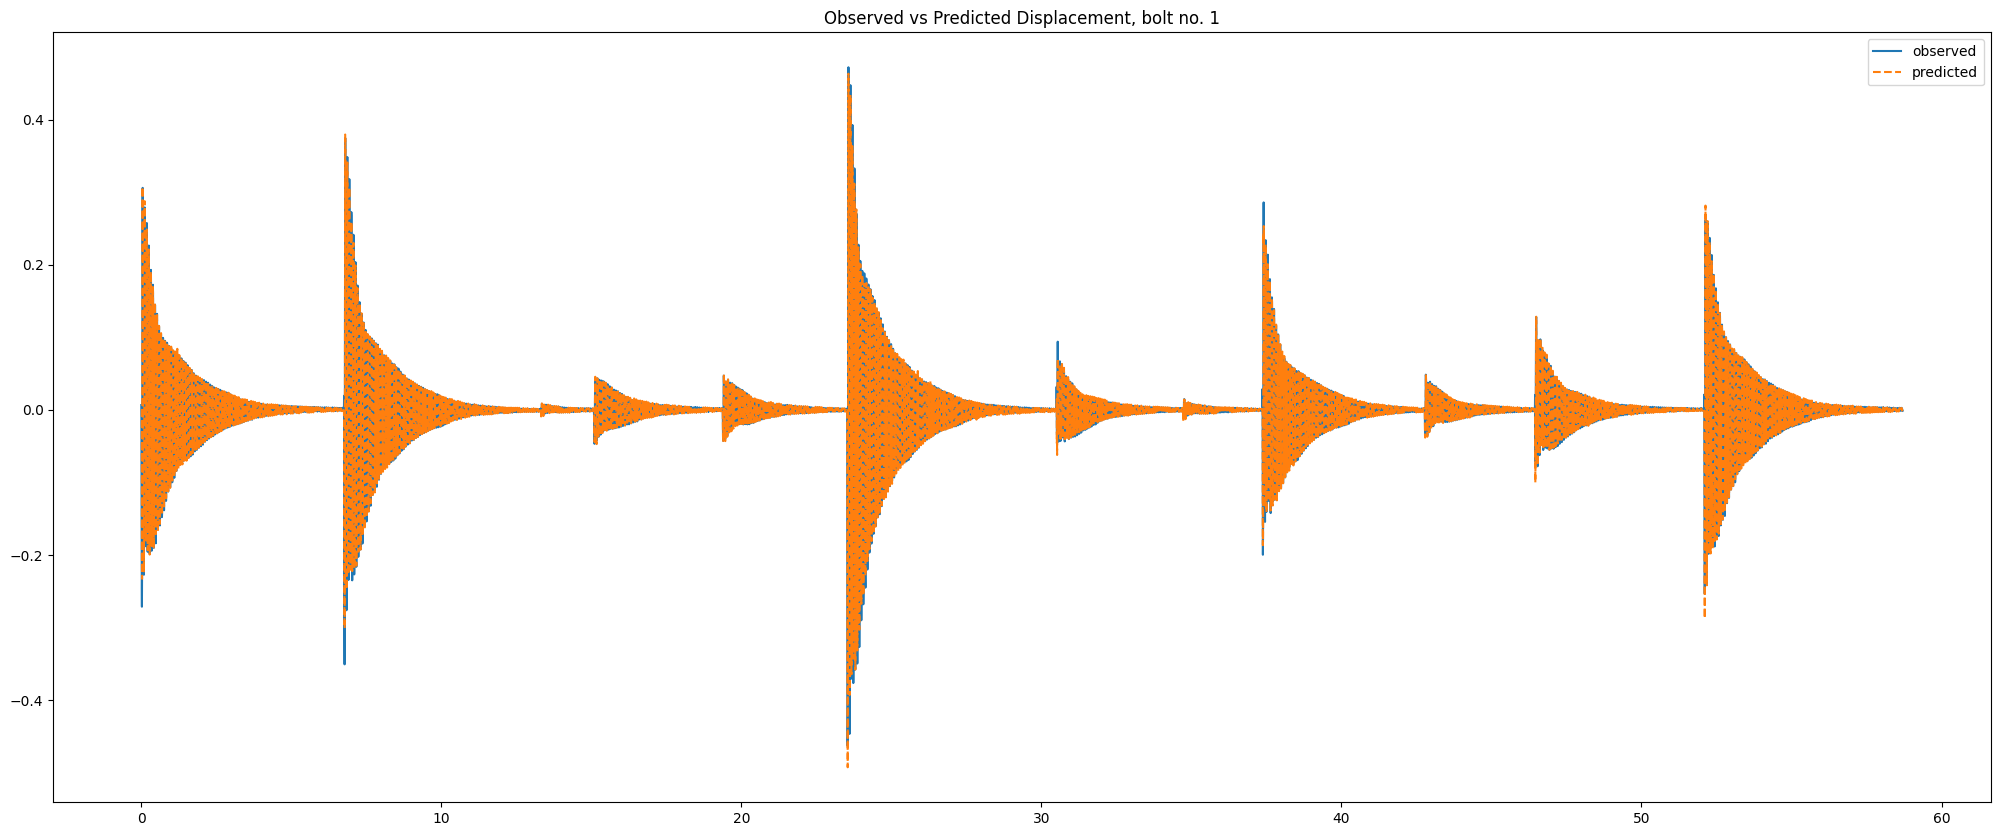

In [861]:
test_bolt_actual = stacked_test_data[0, :]
test_bolt_pred = test_preds[0, :]

test_bolt_pred = np.concatenate([np.zeros(delay), test_bolt_pred])

print("test series shape", test_bolt_actual.shape)
print("Y_pred shape", test_bolt_pred.shape)

fig, ax = plt.subplots(1, 1, figsize=(25, 10))
t = get_time_from_frames(test_bolt_actual.shape[0])
ax.plot(t, test_bolt_actual, label='observed')
ax.plot(t, test_bolt_pred, label='predicted', linestyle='--')      
ax.legend()
plt.title('Observed vs Predicted Displacement, bolt no. 1')
plt.show()


Looks to be working well. Lets zoom in to a single prediction so that we can see if there is anything funky happening at the transition between timeseries.

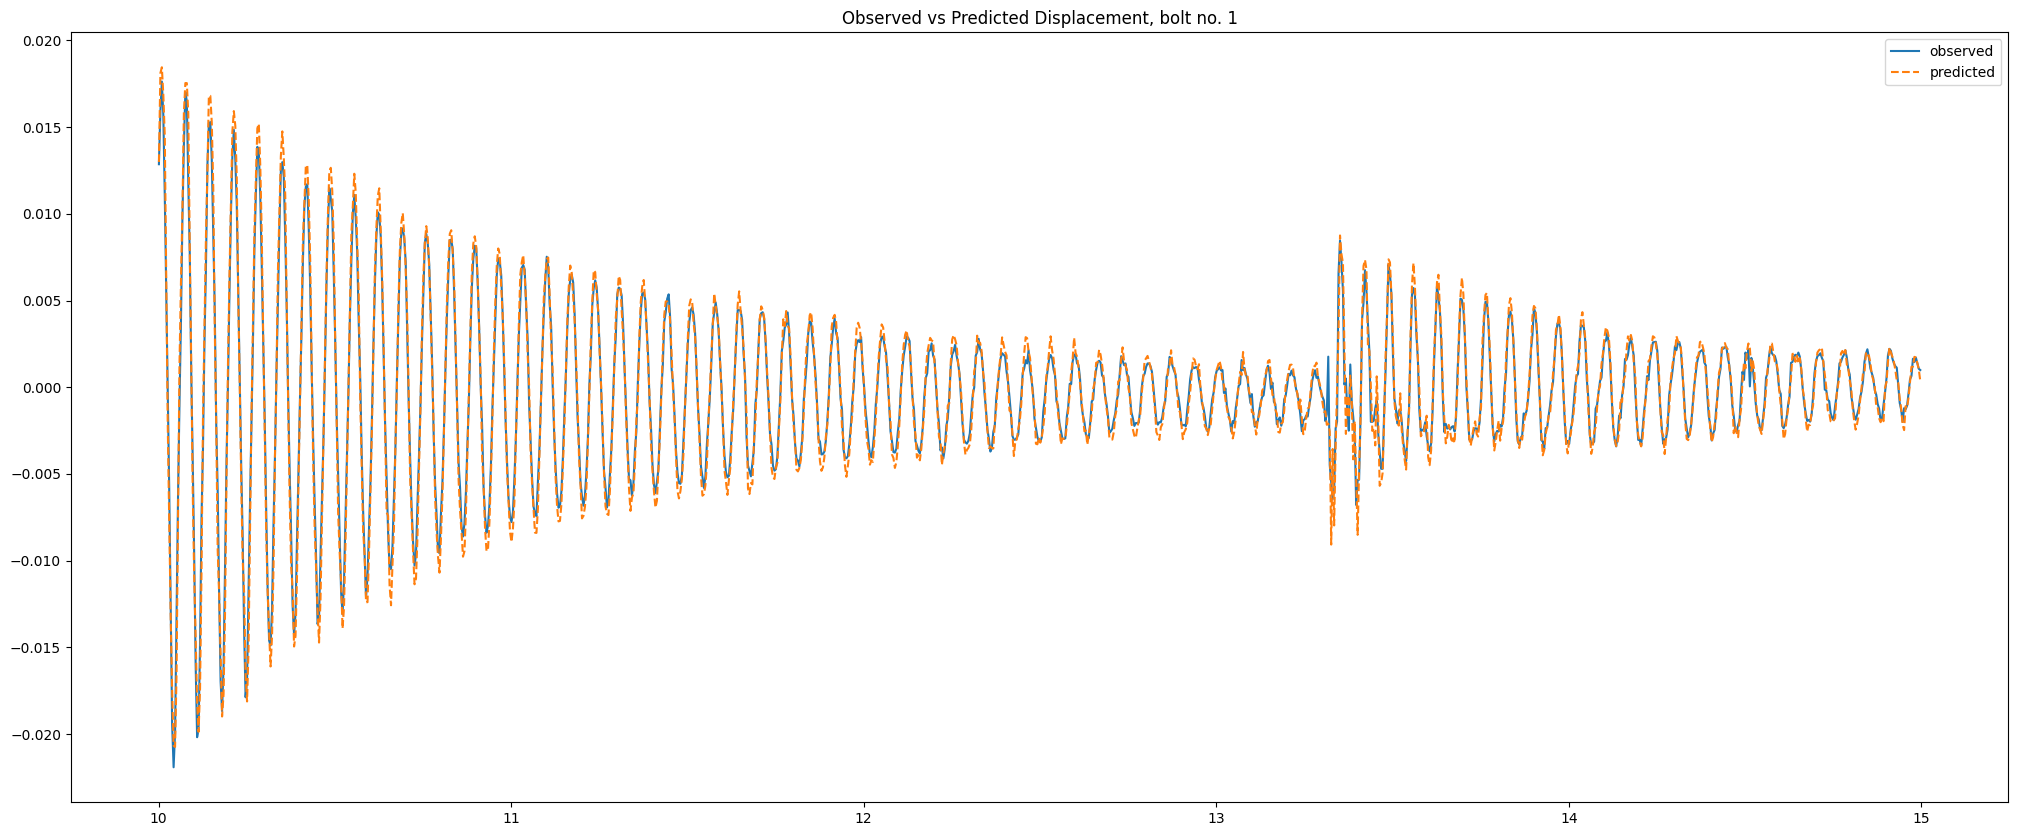

In [862]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
inds = np.where(np.logical_and(t>10, t<15))[0]
t = t[inds]
ax.plot(t, test_bolt_actual[inds], label='observed')
ax.plot(t, test_bolt_pred[inds], label='predicted', linestyle='--')      
ax.legend()
plt.title('Observed vs Predicted Displacement, bolt no. 1')
plt.show()

We can see that there is some small error at the peaks and troughs of the oscillations and that the transition to the next timeseries does seem to impose a small amount of error, but this is not significant since it only occurs for a small fraction of the timesteps. We can also see that the model does not predict the slight anomalies in the oscillation seen between t=14 and t=15, which is a good initial sign that the model is not overfit.

## 2.2 and 2.3

Lets find the smallest delay such that the difference between the train and test error is smaller than 10%. We can also look at the standard deviation during this task.

In [863]:
def train_and_compare(train, test, delay, kappa=1e6):
    W, U, _, _ = linear_delay_embedding(stacked_train_data, delay=delay, kappa=kappa)

    _, train_error_mean, train_error_std = predict(W, U, stacked_train_data, delay=delay)
    _, test_error_mean, test_error_std = predict(W, U, stacked_test_data, delay=delay)

    error_ratio = np.abs(test_error_mean - train_error_mean)/train_error_mean

    return error_ratio, (train_error_mean, test_error_mean), (train_error_std, test_error_std)

# testing the error ratio for different delay values
max_delay = 25
ratios = []
train_stds = []
test_stds = []
train_means = []
test_means = []

delays = list(range(1, max_delay+1))
for delay in delays:
    error_ratio, means, stds = train_and_compare(stacked_train_data, stacked_test_data, delay)
    
    print(f"delay = {delay}, error ratio = {error_ratio}")
    
    # storing values for plotting
    ratios.append(error_ratio)
    train_stds.append(stds[0])
    test_stds.append(stds[1])
    train_means.append(means[0])
    test_means.append(means[1])


delay = 1, error ratio = 0.025882761039742484
delay = 2, error ratio = 0.07932675183321776
delay = 3, error ratio = 0.09639561206002
delay = 4, error ratio = 0.10527696919822231
delay = 5, error ratio = 0.112733463392784
delay = 6, error ratio = 0.12311450790706241
delay = 7, error ratio = 0.1251201087551773
delay = 8, error ratio = 0.13976450441399735
delay = 9, error ratio = 0.1515273121140984
delay = 10, error ratio = 0.1635025104214392
delay = 11, error ratio = 0.17014109237483188
delay = 12, error ratio = 0.18090726769777155
delay = 13, error ratio = 0.1876340384524639
delay = 14, error ratio = 0.19335916170563816
delay = 15, error ratio = 0.20211825921392026
delay = 16, error ratio = 0.21326804655146606
delay = 17, error ratio = 0.2265250705261586
delay = 18, error ratio = 0.2424242476806172
delay = 19, error ratio = 0.2513883222754091
delay = 20, error ratio = 0.26022094955536546
decorrelated matrix has less rows that input data for numerical stability
delay = 21, error ratio = 

We see that the train test ratio decreases with increasing delay until delay = 13, then it starys to increase again. once the delay reaches 23, the decorrelation function produces the warning that the smallest singular values of the correlation matrix violate the numerical stability heuristic, indicating that additional delays do not introduce further information.

### 3.4
Visualising how the standard deviation and mean of the error vary with delay

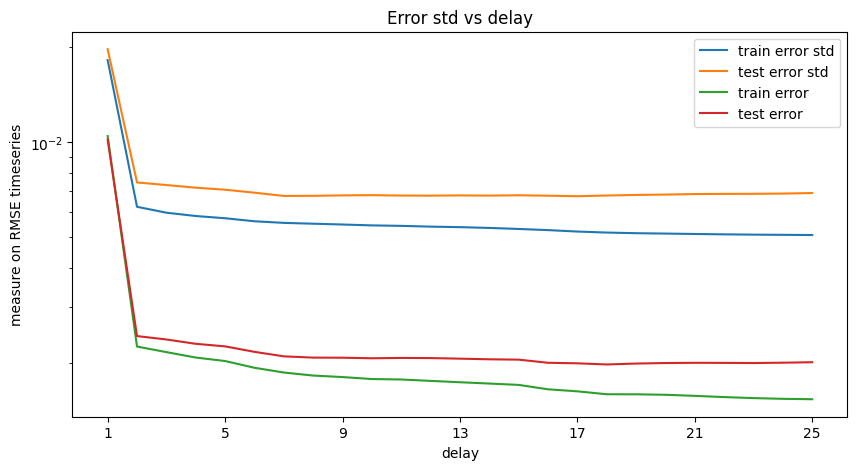

In [864]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(delays, train_stds, label='train error std')
ax.plot(delays, test_stds, label='test error std')
ax.plot(delays, train_means, label='train error')
ax.plot(delays, test_means, label='test error')
ax.legend()
plt.title('Error std vs delay')
ax.set_yscale('log')
ax.set_xlabel('delay')
ax.set_ylabel('measure on RMSE timeseries')
ax.set_xticks(delays[::4])
plt.show()

We can see that there is a sharp drop associated with increasing the delay to 2 (delay of 1 corresponds to simply fitting a linear model to the current output, to predict the next output). There is then a very slight improvement of the mean train and test RMSE until a delay of 13 is reached, at which point the training accuracy continues to decrease whilst the test accuracy remains the same. This train test mismatch indicates the point at which slight overfitting occurs.

High values of standard deviation in the train and test RMSE would indicate that the distribution of error is wide, meaning many points in the prediction actually have an error greater than the mean error. here we see that the standard deviation is $\approx \pm 0.006$ RMSE. Since the optimum mean is $\approx 0.002$, this indicates that the error probably lies within the same magnitude order of magnitude everywhere (we can't be more specific without looking at the distribution of error).

# Problem 3

## 3.1
I'm now going to reimplement the linear model using dimensionality reduction and a delay value of 13 as determined above. Instead of using SVD alone it makes more sense to use PCA, since this preserves the variance of the data. In fact the data has already been centered so the principle components are simply decorrelated data points using SVD.

In [ ]:
def SVD_linear_test(delay: int):
    dimensions = list(range(1, train_data[0].shape[0]*delay+1))

    train_rmses = []
    test_rmses = []
    train_stds = []
    test_stds = []

    for dim in dimensions:
        W, U, _, _ = linear_delay_embedding(stacked_train_data, delay=delay, kappa=kappa, svd_rank=dim)

        _, train_rmse, train_std = predict(W, U, stacked_train_data, delay=delay)
        _, test_rmse, test_std = predict(W, U, stacked_test_data, delay=delay)

        train_rmses.append(train_rmse)
        test_rmses.append(test_rmse)
        train_stds.append(train_std)
        test_stds.append(test_std)

        if dim == delay:
            W_view = W

    # plotting errors vs PCA dimension
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(dimensions, train_rmses, label='train error')
    ax.plot(dimensions, test_rmses, label='test error')
    ax.plot(dimensions, train_stds, label='train error std')
    ax.plot(dimensions, test_stds, label='test error std')
    ax.legend()
    plt.title('RMSE vs PCA dimension')
    ax.set_xlabel('SVD decorrelation rank')
    ax.set_ylabel('RMSE')
    ax.set_yscale('log')
    plt.show()

    # visualising weight matrix
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    mat = ax.matshow(W_view, cmap='coolwarm')
    plt.colorbar(mat, label='Weight value')
    plt.title('Weight matrix for non-linear delay embedding')
    plt.ylabel('SVD rank')
    plt.xlabel('Non-linear function index')
    plt.show()


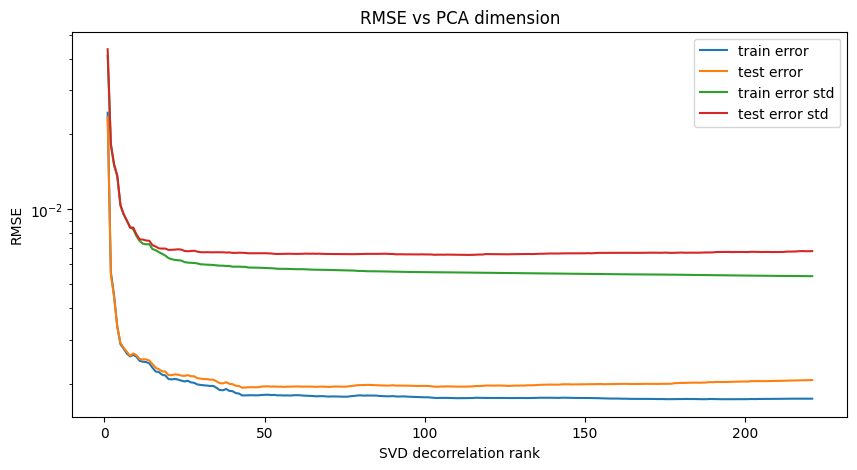

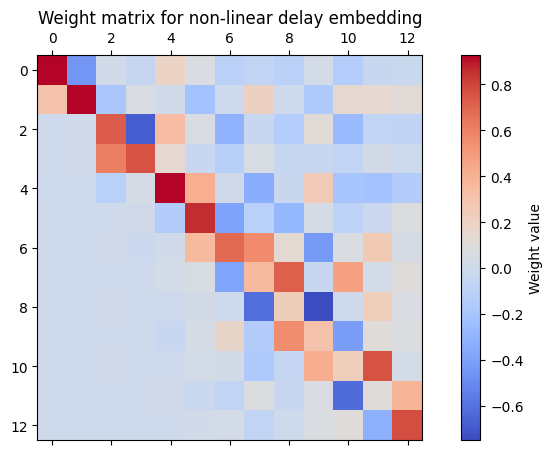

In [882]:
SVD_linear_test(delay=13)

For the linear model we see that as the projected dimension decreases, the train and test errors grow at a roughly equivalent rate.
Using 8 or more of the first principle components does not significantly degrade the training and testing performance. Below this the error appears to grow roughly exponentially, but even using just a single principle component the train and test error is still fairly low (data is normalised to a RMSE approaching 0.1 would be significant error)

In fact if we look at the total explained variance ratio for against number of Principle Components, we see that one dimension alone acounts for 95% of the variance in the original 17 dimensional data. Noteably also, the standard deviation of the error remains similar for all dimensions, implying the distribution of error remains the same. Together these facts suggest that each of the bolts in the experiment roughly follow the same dynamics, and only about 5% of the total variance in the data is position dependent.  






## 3.2

To Fit a quadratic and polynomial model we will have to use a library of nonlinear functions for training, so we must implement this first. If we define a library of nonlinear functions, $\Phi$ then the fitting precedure is loosely

$$
\tilde{X}_{\mathrm{prev}} = \Phi(\hat{X}_{\mathrm{prev}})
$$

$$
W = \hat{X}_\mathrm{next} \tilde{X}_{\mathrm{prev}}^T\big(\tilde{X}_{\mathrm{prev}} \tilde{X}_{\mathrm{prev}}^T\big)^+
$$

$$
\bm{\hat{x}}_{k+1} = W\Phi(\bm{\hat{x}}_{k})
$$

where hats denote decorrelated data and capital X terms are in hankel matrix form

In [ ]:
def nonlinear_delay_embedding(data: np.array, func_library: List[Callable], delay: int = 10, kappa: float = 1e6, svd_rank: int = None):
    """
    Fits a non-linear delay embedding model to predict the next state surrogate from a nonlinear transformation 
    of the previous state surrogate, where the list of applied nonlinear functions is given by func_library.  

    args:
    -----
    data: np.array, timeseries of shape (n, m) where m is the number of timesteps and n is the number of features 
    func_library: List[Callable], list of functions to apply to the previous state surrogate
    delay: int, delay embedding window size
    kappa: float, threshold for decorrelation
    svd_rank: int, number of singular values to keep for decorrelation, if None, all singular values are kept

    returns:
    --------
    W: np.array, non-linear model weights of shape (n, funcs*n)
    U: np.array, LHS Matrix from SVD, for switching between decorrelated state surrogate and observed/predicted outputs
    """
    # delay embedding the observed outputs
    hankel = hankel_matrix(data, delay)
    # previous timestep and next timestep state surrogate matrices
    X_prev = hankel[:, :-1]
    X_next = hankel[:, 1:]
    # decorrelated input state surrogate matrix
    _, U = decorrelate(hankel, kappa=kappa, verbose=False)
    # truncating the left singular vectors to svd_order
    U = U[:, :svd_rank]
    # decorrelated state surrogates
    X_prev = U.T @ X_prev
    X_next = U.T @ X_next

    # applying the library of functions to the previous state surrogates
    func_evals = []
    for func in func_library:
        func_eval = func(X_prev)
        func_evals.append(func_eval)

    nl_X_prev = np.concatenate(func_evals, axis=0) # result is (funcs*n, obs-delay)
    
    # fitting a linear model to the new nonlinear state space
    W = (X_next @ nl_X_prev.T) @ la.pinv(nl_X_prev @ nl_X_prev.T, rcond=1e-8)

    return W, U

def predict_nonlinear(W: np.array, U: np.array, data: np.array, func_library: List[Callable], delay: int):
    """
    predicts the output state at the next timestep using a non-linear delay embedding model, 
    with learned weights W, delay d, decorrelation matrix U and a library of non-linear functions
    given by func_library.
    
    args:
    -----
    W: np.array, linear model weights of shape (n, funcs*n)
    U: np.array, LHS Matrix from SVD, for decorrelation
    data: np.array, test trajectory of shape (n,m) where m is the number of timesteps and n is the number of features
    d: int, delay embedding window size

    returns:
    --------
    Y_pred: np.array, predicted output trajectory
    prediction_rmse: float, root mean squared error of the prediction vs the actual output
    """
    # delay embedding matrix
    hankel = hankel_matrix(data, delay)
    # decorrelated previous state surrogate matrix
    X_prev = U.T @ hankel[:, :-1]
    
    # evaluating data through the library of functions
    func_evals = []
    for func in func_library:
        func_eval = func(X_prev)
        func_evals.append(func_eval)

    nl_X_prev = np.concatenate(func_evals, axis=0) # result is (funcs*n, obs-delay)
    
    # predicting the next state surrogate
    X_next_pred = W @ nl_X_prev
    print(X_next_pred.shape)
    
    # predicting the output at unseen timesteps
    Y_pred = U[-data.shape[0]:, :] @ X_next_pred
    Y_actual = data[:, delay:]

    # calculating the rmse for each timestep over the 17 bolts
    rmse = la.norm(Y_pred - Y_actual, axis=0) / np.sqrt(Y_actual.shape[0]) # shape (m-d,) 
    
    # mean error is then taken over all timesteps
    mean_error = np.mean(rmse)
    std_error = np.std(rmse)

    return Y_pred, mean_error, std_error

def SVD_non_linear_test(func_library: List[Callable], delay: int):
    dimensions = list(range(1, train_data[0].shape[0]*delay+1))

    train_rmses = []
    test_rmses = []
    train_stds = []
    test_stds = []

    for dim in dimensions:

        W, U = nonlinear_delay_embedding(stacked_train_data, func_library, delay=delay, kappa=kappa, svd_rank=dim)

        _, train_rmse, train_std = predict_nonlinear(W, U, stacked_train_data, func_library, delay=delay)
        _, test_rmse, test_std = predict_nonlinear(W, U, stacked_test_data, func_library, delay=delay)

        train_rmses.append(train_rmse)
        test_rmses.append(test_rmse)
        train_stds.append(train_std)
        test_stds.append(test_std)
        # saving weight matrix for delay == rank
        if dim == delay:
            W_view = W

    # plotting errors vs SVD rank
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(dimensions, train_rmses, label='train error')
    ax.plot(dimensions, test_rmses, label='test error')
    ax.plot(dimensions, train_stds, label='train error std')
    ax.plot(dimensions, test_stds, label='test error std')
    ax.legend()
    ax.set_title('RMSE vs SVD Rank delay = {}'.format(delay))
    ax.set_xlabel('SVD Rank')
    ax.set_ylabel('RMSE')
    ax.set_yscale('log')
    plt.show()

    # visualising weight matrix
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    mat = ax.matshow(W_view, cmap='coolwarm')
    plt.colorbar(mat, label='Weight value')
    plt.title('Weight matrix for non-linear delay embedding')
    plt.ylabel('SVD rank')
    plt.xlabel('Non-linear function index')
    plt.show()
    

Now let's train and test a quadratic polynomial model with function library [lambda x: np.ones_like(x), lambda x: x, lambda x: x**2]

In [ ]:
SVD_non_linear_test([lambda x: np.ones_like(x), lambda x: x, lambda x: x**2], delay=8)

(1, 15311)
(1, 14081)
(2, 15311)
(2, 14081)
(3, 15311)
(3, 14081)
(4, 15311)
(4, 14081)
(5, 15311)
(5, 14081)
(6, 15311)
(6, 14081)
(7, 15311)
(7, 14081)
(8, 15311)
(8, 14081)
(9, 15311)
(9, 14081)
(10, 15311)
(10, 14081)
(11, 15311)
(11, 14081)
(12, 15311)
(12, 14081)
(13, 15311)
(13, 14081)
(14, 15311)
(14, 14081)
(15, 15311)
(15, 14081)
(16, 15311)
(16, 14081)
(17, 15311)
(17, 14081)
(18, 15311)
(18, 14081)
(19, 15311)
(19, 14081)
(20, 15311)
(20, 14081)
(21, 15311)
(21, 14081)
(22, 15311)
(22, 14081)
(23, 15311)
(23, 14081)
(24, 15311)
(24, 14081)


KeyboardInterrupt: 

Fitting the nonlinear quadratic model we see a similar picture to the linear model, but with slightly less increase in the training error as the number of principle components is reduced. EXPAND ON THIS

## 3.3
training and testing a cubic polynomial model

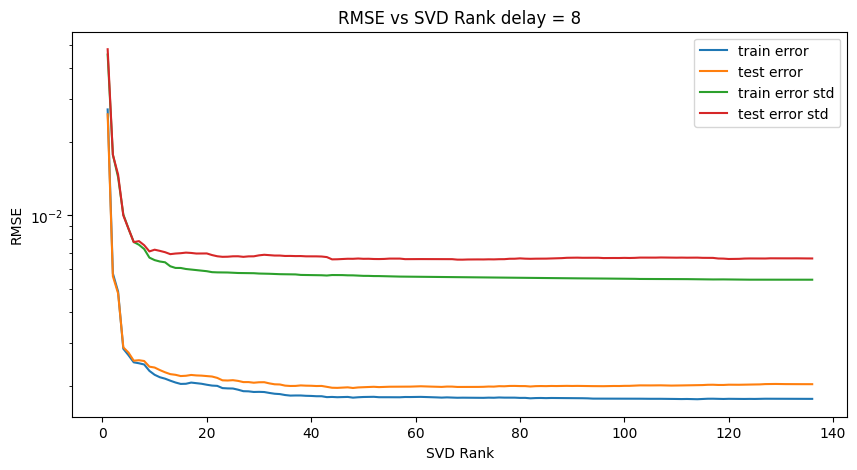

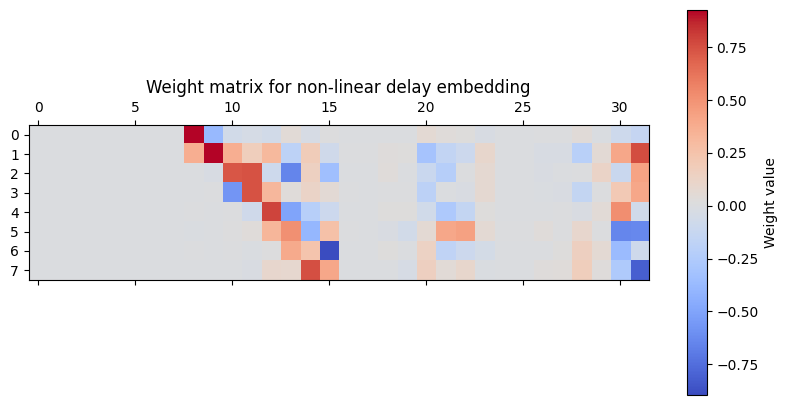

In [ ]:
SVD_non_linear_test([lambda x: np.ones_like(x), lambda x: x, lambda x: x**2, lambda x: x**3], delay=8)

Again, we see a similar picture.

## 3.4

In all of the models tested there is a slight increase in the standard deviation of the test error between 2 and 3 dimensions, whilst the train std decreases. This suggests there may be some slight overfitting in the model in higher dimensions, since the train and test error distribution becomes mismatched. 

## 4.1

We can calculate the DMD of a linear system as a special case given
$$
\hat{\bm{x}}_{k+1} = W\hat{\bm{x}}_k
$$
where W is our learned linear model and $\hat{\bm{x}}_k$ is the state surrogate at timestep k.
Then koopman modes are
$$
h(\hat{\bm{x}}_{k+1}) = h(W\hat{\bm{x}}_k) = \lambda h(\hat{\bm{x}}_k)
$$
and if we assume that the koopman operator is given by 
$$
h(\hat{\bm{x}}) = \bm{v}^T\hat{\bm{x}}
$$
where $\bm{v}^T\hat{\bm{x}}$ is the eigenfunction of a particular koopman mode, we then have 
$$
W^T\bm{v} = \lambda\bm{v}^T
$$
Koopman modes include the eigenvalue, eigenfunction pairs of W (corresponding to left eigenvectors of W).

Because the koopman operator is linear, the rest of the koopman modes can be determined from the unique products of these solutions. For a linear model there are a finite number of koopman modes provided none of the eigenvalues are equal to one.


In [870]:
def linear_DMD(W):
    """
    return the eigenvalues and DMD matrix corresponding to the approximate koopman modes 
    a linear model, with square weight matrix W.
    
    Returns:
    --------
    W_eigvals: np.array, eigenvalues of the DMD matrix, sorted by decreasing magnitude
    dmd_mat: np.array, DMD matrix each row of which corresponds to a koopman function (left eigenvectors of W)
    """

    # we want the left eigenvectors, so we need to transpose W. W is of course symettric in this case so we can use eig
    W_eigvals, W_eigvecs = la.eig(W.T)
    # sorting the eigenvectors by the magnitude of the eigenvalues
    sort_indices = np.argsort(np.abs(W_eigvals))[::-1]
    W_eigvals = W_eigvals[sort_indices]
    W_eigvecs = W_eigvecs[:, sort_indices]

    # The first order DMD matrix is simply
    dmd_mat = W_eigvecs.T

    return W_eigvals, dmd_mat    

In [871]:
# let's just retrain the model to get the weights
W, U, X_prev, X_next = linear_delay_embedding(stacked_train_data, delay=8, kappa=1e6)

W_eigvals, dmd_mat = linear_DMD(W)

## 4.2

The residual of a given DMD mode, measures how close we are to an actual koopman mode. It is given by

$$
res(\lambda, h) = \frac{\|\Kappa h - \lambda h \|^2}{\|h\|^2}
$$

where $\kappa h$ is the actual koopman operator and $\lambda h$ is the DMD approximation. To approximate this residual with data, we can use the equation

$$
res(\lambda, h) \approx \frac{\bm{v}^*\big( L - \lambda H - \bar{\lambda}H^T + |\lambda|^2 G \big)\bm{v}}{\bm{v}^* G\bm{v}}
$$

where $G=XX^T$, $H=YX^T$ and $L = YY^T$

and in this case, since we have a linear model,
$Y=\hat{X}_{\mathrm{prev}}$, $X = \hat{X}_{\mathrm{prev}}$, with $Y = WX$

More precisely, the residual is the relative error between the approximate koopman mode and actual koopman mode.

In [872]:
## 4.2
def koopman_residue(X, Y, eigen_val, eigen_vec):
    """
    Calculates the approximate residual of the Koopman mode, corresponding to eigen_val and eigen_vec, 
    using the input and output state data X and Y.
    args:
    -----
    X: np.array, input state matrix of shape (n, m) where n is the number of features and m is the number of timesteps
    Y: np.array, output state matrix of shape (n, m) where n is the number of features and m is the number of timesteps
    koop_val: float, value of the koopman operator
    eigen_vec: np.array, eigenvector of the Koopman operator

    returns:
    --------
    residue: float, residue of the Koopman operator
    """

    G = X @ X.T
    H = Y @ X.T
    L = Y @ Y.T

    v = eigen_vec
    lam = eigen_val

    # shorthand for the hermitian transpose
    def HT(v: np.array) -> np.array:
        return np.conj(v).T
    
    res = HT(v) @ (L - lam*H - np.conj(lam)*HT(H) + np.abs(lam)**2*G) @ v
    res /= HT(v) @ G @ v

    # Because of machine precision, the residue can be a complex number with a very small imaginary part
    assert np.isclose(np.imag(res), 0, atol=1e-15), 'Residue is not real to machine precision'
    res = np.real(res)

    return res

lets calculate the residual of each of the modes

In [873]:
def sorted_koopman_residues(W_eigvals, dmd_mat, X_prev, X_next, return_inds=False):
    no_modes = W_eigvals.shape[-1]

    # getting the residue of each approximate koopman mode
    residues = []
    for i in range(no_modes):
        residue = koopman_residue(X_prev, X_next, W_eigvals[i], dmd_mat[i, :])
        residues.append(residue)
    residues = np.array(residues)
    
    # sorting the residues and the corresponding eigenvalues and eigenvectors by the residues
    sort_inds = np.argsort(residues)
    residues = residues[sort_inds]
    W_eigvals = W_eigvals[sort_inds]
    dmd_mat = dmd_mat[sort_inds, :]

    # returning the sorted residues, eigenvalues and dmd matrix (eigenvectors)
    if return_inds:
        return residues, W_eigvals, dmd_mat, sort_inds
    
    return residues, W_eigvals, dmd_mat

residues, W_eigvals, dmd_mat = sorted_koopman_residues(W_eigvals, dmd_mat, X_prev, X_next)

print("residues: ", residues)
print("number of modes: ", len(residues))

residues:  [0.00792457 0.00792457 0.03026176 0.03026176 0.08850787 0.09084807
 0.09084807 0.12505805 0.12505805 0.13566094 0.18771946 0.18771946
 0.1945194  0.1945194  0.21871785 0.21871785 0.23790645 0.23790645
 0.25361219 0.25361219 0.25555083 0.27931474 0.27931474 0.28798219
 0.28798219 0.29155185 0.29155185 0.30042599 0.30042599 0.31329208
 0.31329208 0.32475315 0.32475315 0.32585114 0.32585114 0.32996165
 0.32996165 0.33668019 0.35168814 0.35168814 0.35872398 0.35872398
 0.36588061 0.36588061 0.38004552 0.38004552 0.38118463 0.38118463
 0.38137145 0.38137145 0.38779059 0.38779059 0.40860284 0.40860284
 0.4100954  0.4100954  0.42037908 0.42037908 0.4223956  0.4223956
 0.42328552 0.42328552 0.42391638 0.42391638 0.43104164 0.43104164
 0.43155758 0.43155758 0.43308595 0.43308595 0.43933829 0.43933829
 0.43941221 0.43941221 0.44136643 0.44136643 0.45487731 0.45487731
 0.46356991 0.46356991 0.46694599 0.46694599 0.46880412 0.46880412
 0.47278929 0.47278929 0.47596449 0.47596449 0.48005

## 4.3

We have 136 modes because we are using a delay of 8 for our linear delay embedding model (17*8). We see that the worst residual is close to 1, which would indicate the approximate mode is off by a whole factor of the true solution. However, this might be the case if the eigenvalue of the mode is very close to zero. Let's take a look by plotting the eigenvalues in the complex plane, colorcoded by residue.

In [874]:
def plot_koopman_modes(eigvals, residues):
    """
    Plots the first n_modes Koopman modes, corresponding to the eigenvalues eigvals and eigvecs.
    args:
    -----
    eigvals: np.array, eigenvalues of the Koopman operator
    eigvecs: np.array, eigenvectors of the Koopman operator
    n_modes: int, number of modes to plot
    """
    fig, ax = plt.subplots()
    # seperating real and imaginary parts for plotting
    eigvals_x = np.real(eigvals)
    eigvals_y = np.imag(eigvals)
    scat = ax.scatter(eigvals_x, eigvals_y, c=residues, cmap='jet')
    # plot unit circle
    unit_circle = plt.Circle((0, 0), 1, color='r', fill=False, linestyle='--', label='unit circle')
    ax.add_artist(unit_circle)
    
    # formatting
    ax.set_xlabel('Real')
    ax.set_ylabel('Imaginary')
    ax.set_title('Koopman modes')
    plt.colorbar(scat, label='Residue')
    # setting limits so that the unit circle is central and visible
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.legend(loc='upper left')

    plt.show()

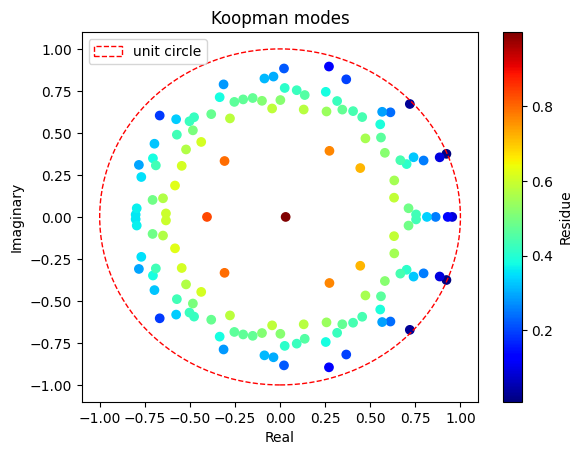

In [875]:
plot_koopman_modes(W_eigvals, residues)

We can see that our theory of smaller eigenvalues producing larger residuals is correct. Now when it comes to plotting the frequencies, that each koopman mode corresponds to, we must first consider what this means. We saw previously, that under the koopman operator, our linear observable system follows the update rule

$$
h(\hat{\bm{x}}_{k+1}) = \lambda h(\hat{\bm{x}}_k)
$$

meaning, given some timestep $\Delta t$ and initial output, producing the surrogate state $\hat{\bm{x}}_0$, we have the power rule

$$
h(\hat{\bm{x}}(t)) = \lambda^{t/\Delta t} h(\hat{\bm{x}}_0)
$$

which in exponential form is

$$
h(\hat{\bm{x}}(t)) = e^{\ln(\lambda)(t/\Delta t)} h(\hat{\bm{x}}_0)
$$

This can be rewritten as a decaying complex exponential, since $\ln(\lambda)$ is complex

$$
h(\hat{\bm{x}}(t)) = f(t)e^{i\theta t}
$$

where
$$
f(t) = h(\hat{\bm{x}}_0)e^{\frac{1}{\Delta t}\mathrm{Re}\{\ln(\lambda)\}t}
$$

and

$$
\theta = \frac{1}{\Delta t}\mathrm{Im}\{\ln(\lambda)\}
$$


A really cool implication of this, is that the full koopman space solution is a fourier series solution to the underlying system, since each koopman mode defines a decaying (since all the koopman eigenvalues lie in the complex unit circle) sinusoidal function. In any case, the frequency of the koopman mode corresponding to $h$ is given by $\theta$ (rad/s). The decay exponent of each koopman mode is also given by $\frac{1}{\Delta t}\mathrm{Re}\{\ln(\lambda)\}\,\, s^{-1}$

Let's plot this and we can go one step further and plot the sinsusoids corresponding to each mode.

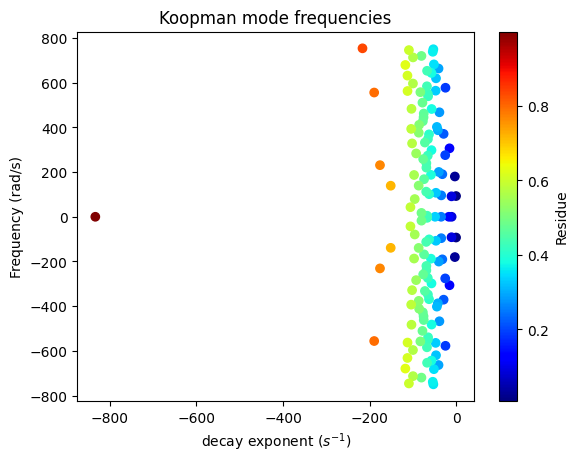

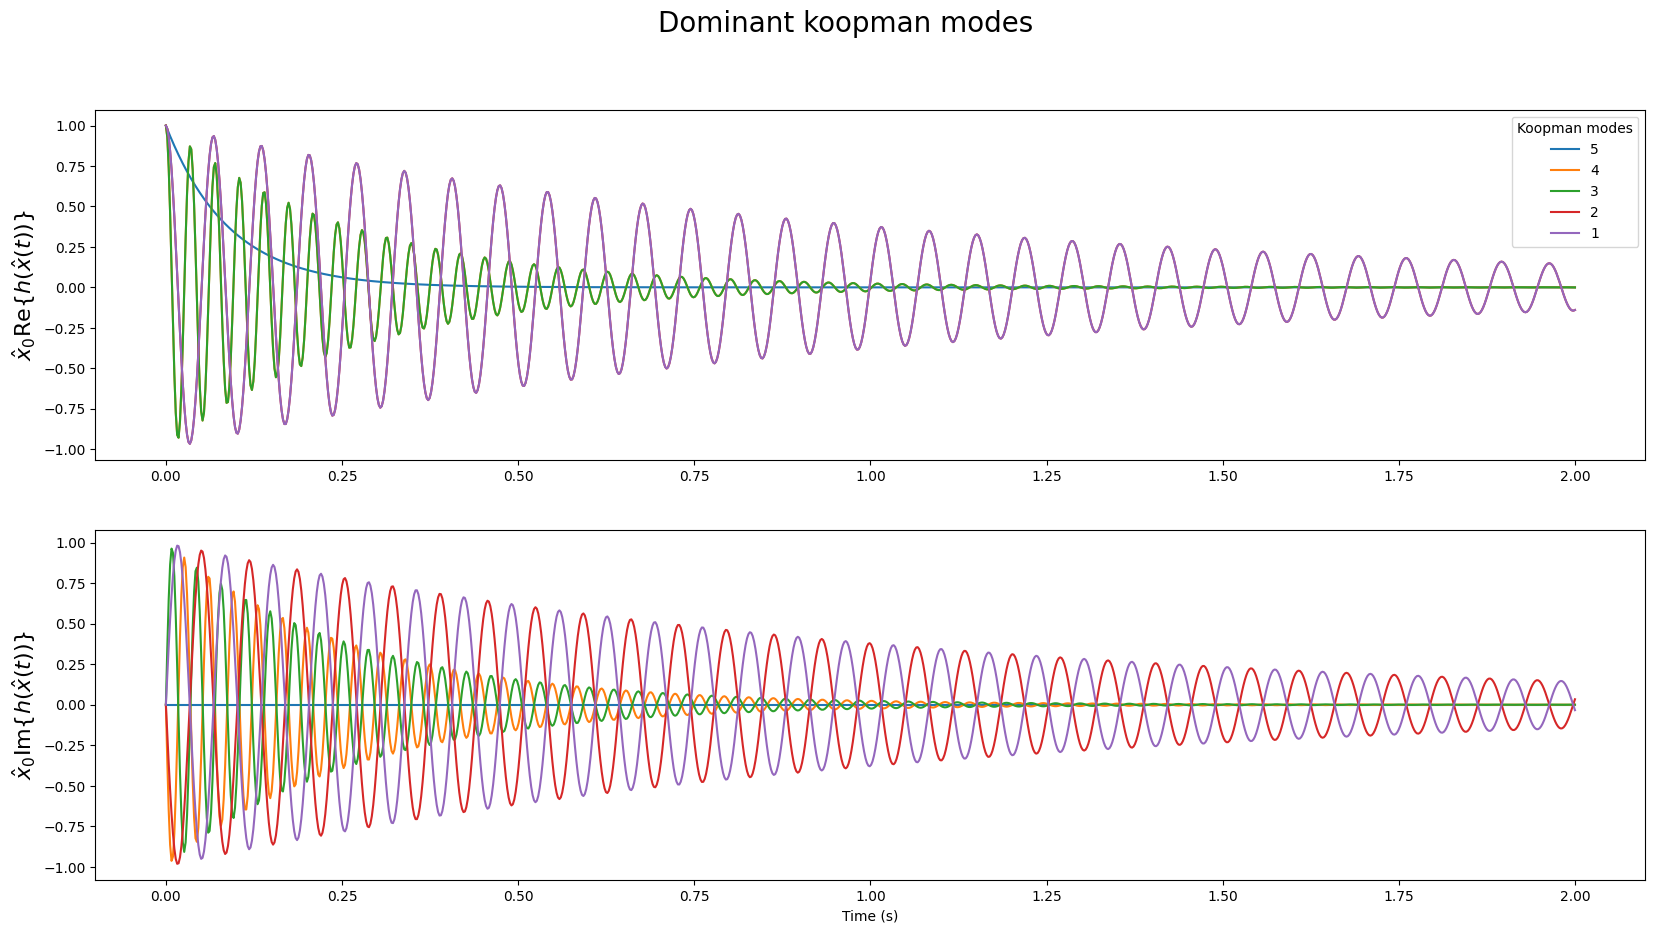

In [876]:
def koopman_space_solution(eig_val, t, delta_t):
    """
    Calculates the koopman space state solution at time t, where ther koopman operator being solved is given by eig_val. 
    args:
    -----
    eig_val: float, eigenvalue of the Koopman operator
    t: float, time to evaluate the solution
    x_0: np.array, initial condition of the system

    returns:
    --------
    x_t: np.array, solution to the Koopman operator at time t
    """
    koop_xt = np.exp(1/delta_t * np.real(np.log(eig_val)) * t)*np.exp(1j/delta_t * np.imag(np.log(eig_val)) * t)
    return koop_xt


def plot_koopman_mode_frequencies(eig_vals, residuals, delta_t):
    """
    Plots the frequency of the Koopman modes, corresponding to the eigenvalues eig_vals and residuals.
    args:
    -----
    eig_vals: np.array, eigenvalues of the Koopman operator
    residuals: np.array, residues of the Koopman operator
    delta_t: float, time step between each state in the data
    """
    # calculating the frequencies of the Koopman modes
    freqs = 1/delta_t * np.imag(np.log(eig_vals))
    # calculating the decay exponents of the Koopman modes
    decay_expo = 1/delta_t * np.real(np.log(eig_vals))

    fig, ax = plt.subplots()
    scat = ax.scatter(decay_expo, freqs, c=residuals, cmap='jet')
    ax.set_xlabel('decay exponent ($s^{-1}$)')
    ax.set_ylabel('Frequency (rad/s)')
    ax.set_title('Koopman mode frequencies')
    plt.colorbar(scat, label='Residue')
    plt.show()

    slowest_decaying = np.argsort(decay_expo)[-5:]

    fig, axs = plt.subplots(2, 1, figsize=(20, 10))
    t = np.linspace(0, 2, 1000)
    for i in slowest_decaying:
        koop_sol = koopman_space_solution(eig_vals[i], t, delta_t)
        axs[0].plot(t, np.real(koop_sol), label=f'{i+1}')
        axs[1].plot(t, np.imag(koop_sol), label=f'{i+1}')
    
    axs[0].legend(title='Koopman modes')
    axs[0].set_ylabel(r'$\hat{x}_0\mathrm{Re}\{h(\hat{x}(t))\}$', fontsize=16)
    axs[1].set_ylabel(r'$\hat{x}_0\mathrm{Im}\{h(\hat{x}(t))\}$', fontsize=16)
    axs[1].set_xlabel('Time (s)')
    
    plt.suptitle('Dominant koopman modes', fontsize=20)
    plt.show()

# we can determine delta_t from the framerate of the camera
plot_koopman_mode_frequencies(W_eigvals, residues, 1/FRAME_RATE)


The top plot is a really powerful visualisation, as it shows us that our innacurate koopman modes correspond to system dynamics that very quickly decay to zero and the more accurate modes are more persistent in the system dynamics. We also see that there is a conjugate symmetry in the modes, corresponding to orthogonal oscillations.

The bottom plot shows the real and imaginary dimensionless response of the top 5 dominant koopman modes in koopman space. We can see that that modes 1 and 2, together with 3 and 4 are conjugate modes and that mode 5 is actually non oscillatory, instead exhibiting a real exponential decay and 0 imaginary part. when transforming from the koopman space to the surrogate state space, these modes will be linearly combined according to the eigenfunctions of each mode to produce the dynamics of each of the bolts.

## 4.4


In [ ]:
# to implement bagging, we want to repeatedly fit the model to different ordered subsets of the data

def dmd_bagging(trails=50):
    """
    Finds the eigenvalue corresponding to the koopman mode with smallest residue repeatedly
    using bagging. The returned result can be used to quantify the uncertainty in the eigenvalue
    
    returns:
    --------
    eigvals: np.array, eigenvalues from each trial corresponding to the smallest residue
    residuals: np.array, residuals of the eigenvalues from each trial
    mean_eigval: np.array, 2 entry array with the mean of the eigenvalues in the real and imaginary plane
    cov_eigval: np.array, 2x2 array, covariance matrix of the eigenvalues in the real and imaginary plane
    """

    eigvals = []
    residuals = []
    signs = []
    for trial in tqdm(range(trails), desc='Bagging trials'):
        # randomly sampling 80% of the training data and sorting, so that there is some temporal skipping but time is still preserved
        inds = np.random.choice(stacked_train_data.shape[1], size=round(stacked_train_data.shape[1]*0.8), replace=False)
        inds = np.sort(inds)

        # retraining the model on the bagged data
        W, U, X_prev, X_next = linear_delay_embedding(stacked_train_data[:,inds], delay=8, kappa=1e6)
        W_eigvals, dmd_mat = linear_DMD(W) # solution is sorted by eigenvalue magnitude

        # calculating the residuals with all of the data is computationally expensive, so we will only do it for the first 100 columns
        residues, sorted_vals, sorted_dmd = sorted_koopman_residues(W_eigvals, dmd_mat, X_prev[:, :100], X_next[:, :100])
        
        for eigen_val, residue in zip(sorted_vals, residues):
            if not np.isclose(np.imag(eigen_val), 0, rtol=1e-4): # ensuring that the eigenvalue has at least a small imaginary part indicating oscillation
                if trial == 0 or (np.sign(np.real(eigen_val)) == signs and np.sign(np.imag(eigen_val)) == signs):
                    eigvals.append(eigen_val)
                    residuals.append(residue)
                    signs = np.sign(eigen_val)
                    break
        
    
    # eigenvals are complex so distribution is 2D, therefore we need to find the mean and covariance to characterise the distribution
    eigvals = np.array(eigvals)
    real_eigvals = np.real(eigvals)
    imag_eigvals = np.imag(eigvals)

    mean_eigval = [np.mean(real_eigvals), np.mean(imag_eigvals)]
    cov_eigval = np.cov(np.vstack([real_eigvals, imag_eigvals]))

    return eigvals, residuals, mean_eigval, cov_eigval


def visualise_complex_gaussian(obs, residuals, mean, cov):
    """
    Visualises a 2D complex gaussian distribution given by the mean and covariance
    args:
    -----
    obs: np.array, observed data points
    residuals: np.array, residuals of the observed data points
    mean: np.array, mean of the complex gaussian
    cov: np.array, covariance matrix of the complex gaussian
    """
    gaus_2d = multivariate_normal(mean=mean, cov=cov)
    real_range = (np.min(np.real(obs)), np.max(np.real(obs)))
    imag_range = (np.min(np.imag(obs)), np.max(np.imag(obs)))
    real, imag = np.meshgrid(np.linspace(*real_range, 100), np.linspace(*imag_range, 100))

    # plotting 
    fig, ax = plt.subplots()
    
    ax.contourf(real, imag, gaus_2d.pdf(np.dstack([real, imag])))
    scat = ax.scatter(np.real(obs), np.imag(obs), c=residuals, label='observed', cmap='jet')
    ax.set_xlabel('Real')
    ax.set_ylabel('Imaginary')
    ax.set_title('Complex Gaussian distribution')
    ax.set_xlim(real_range)
    ax.set_ylim(imag_range)
    plt.colorbar(scat, label='Residue')
    plt.legend()
    plt.show()


         

In [878]:
bagged_eigvals, residuals, mean, cov = dmd_bagging(trails=50)
print("mean eigenvalue: ", mean)
print("covariance of eigenvalues: ", cov)

Bagging trials: 100%|██████████| 50/50 [00:09<00:00,  5.31it/s]

mean eigenvalue:  [0.8644915574395524, 0.4313479270836765]
covariance of eigenvalues:  [[ 1.42648294e-05 -6.06146233e-05]
 [-6.06146233e-05  1.60818472e-02]]


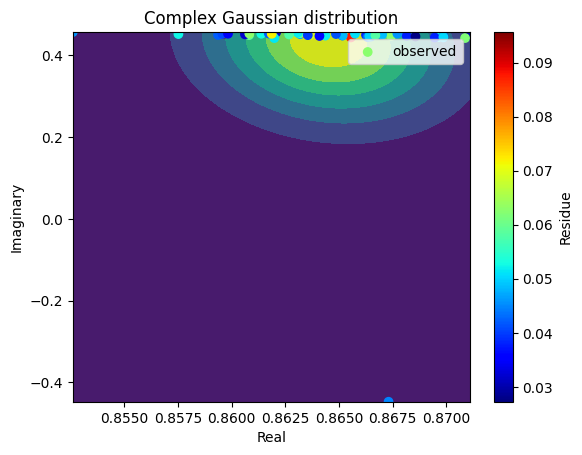

In [879]:
visualise_complex_gaussian(bagged_eigvals, residuals, mean, cov)

## 4.5

We know that the vibration frequency of a given koopman mode is proportional to the log of the imaginary component of the eigenvalue.
More specifically

$$
\theta = \frac{1}{\Delta t}\mathrm{Im}\{\ln(\lambda)\}
$$

we can use the covariance matrix to get an estimate of the standard deviation in the imaginary axis, which quantifies our uncertainty. The corresponding uncertainty of the frequency $\theta$ can be calculated as follows (assuming all other variables are certain)

In [880]:
im_sig = np.sqrt(cov[1,1])
im_mean = mean[1]
# 95% confidence interval is
interval_95 = norm.interval(0.95, loc=im_mean, scale=im_sig)
print(r"95% lambda confidence interval = ", interval_95)

theta_uncertainty = FRAME_RATE * (np.log(interval_95[1]) - np.log(mean[1]))
print(r"frequency 95% uncertainty =  +-", theta_uncertainty, "rad/s")

95% lambda confidence interval =  (0.18279661694608718, 0.6798992372212658)
frequency 95% uncertainty =  +- 109.20710082491097 rad/s


So we can see qualitively from the diagram and quantitavely from the calculated 95% uncertainty that the uncertainty in the frequency is fairly low for these residues. Suggesting that this koopman mode is a good approximation.